# ECE4179 Final Project
This project is about comparing the performance of Pytorch pretrained network ResNet18 with Google Cloud AutoML Vision's performance in classification slides of breast histology using ResNet18 model. The following are the codes that are used in this project to obtain the performance of the pretrained Pytorch ResNet18 model.

## Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torchvision.models as models
import time
from numpy import loadtxt
import cv2
import imutils
from PIL import Image
from numpy import savetxt

## Process original data
The original images will be loaded. According to the journal "A machine learning model for detecting invasive ductal carcinoma with Google Cloud AutoML Vision", large portion of positive images are rotated. In this project, 45% positive images are rotated 90 degrees, 45% positive images are rotated 180 degrees, and the remaining remains the same. 

### Load data
First, we need to load the original data and its corresponding labels.

In [2]:
#Load original image data
data = loadtxt('data.csv', delimiter=',')

#Load label of image data
label = loadtxt('label.csv', delimiter=',')

### Allocate dataset for rotation
Then, we obtain the indices for positive images that need to be rotated by 90 degrees, 180 degrees or remain unchanged, as well as indexes for negative images. We can ensure random distribution of images that will be rotated by different angles by assigning the indices of positive images randomly for the images to be rotated. Then, we assign those indices to allocate the images to be processed accordingly.

In [3]:
#Obtain index where images are with IDC
positive = np.where(label==1)
positive = positive[0]

#Obtain index where images are without IDC
negative = np.where(label==0)
negative = negative[0]

#Shuffle the index of positive images with a fixed random seed
random.Random(520).shuffle(positive)

#Obtain the number of images corresponding to 45% of total positive images
percent_45 = int(0.45*len(positive))

#Assign indices randomly as dataset index for 90 degrees rotation (45%), 180 degrees rotation (45%) and the remaining
#as original data (10%)
deg_90_idx, deg_180_idx, deg_0_idx = positive[0:percent_45], positive[percent_45:2*percent_45], positive[2*percent_45:]

#Obtain images that need to be rotated 90 degrees, 180 degrees and remain untouched

#Images that should be rotated 90 degrees
deg_90_img = data[deg_90_idx]

#Images that should be rotated 180 degrees
deg_180_img = data[deg_180_idx]

#Images that should be remain unchanged
deg_0_img = data[deg_0_idx]

### Process images for 90 degrees rotation
We will first visualise the images without rotation. Then, we will again visualise the images after 90 degrees rotation to verify the 90 degrees rotation has been accomplished successfully.

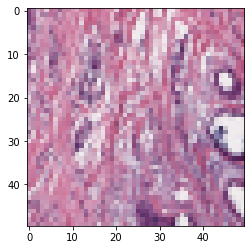

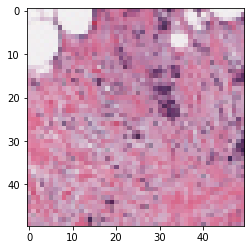

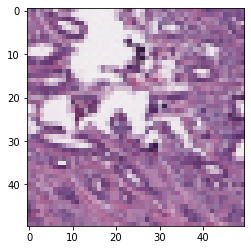

In [4]:
#Visualise 3 positive images before 90 degrees rotation
for i in range(3):
    
    #Process image by reshaping and converting it to uint8
    img= deg_90_img[len(deg_90_idx)-1-i]
    img_array=img.reshape(50,50,3)
    img_array = img_array.astype(np.uint8)

    #Display image
    plt.imshow(img_array)
    plt.show()

In [5]:
#Rotate allocated positive images by 90 degrees
for j in range(len(deg_90_img)):
    
    #Process image by reshaping and converting it to uint8
    img= deg_90_img[j]
    img_array=img.reshape(50,50,3)
    img_array =img_array.astype(np.uint8)
    
    #Rotate image by 90 degrees and update image at the same position
    rot = imutils.rotate(img_array, angle=90)
    new_img = rot.reshape([1,7500])
    deg_90_img[j] = new_img

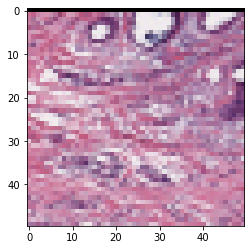

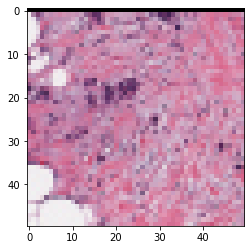

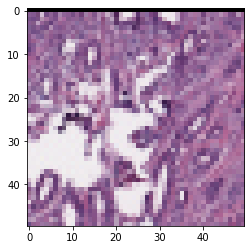

In [6]:
#Visualise 3 positive images after 90 degrees rotation
for i in range(3):
    
    #Process image by reshaping and converting it to uint8
    img= deg_90_img[len(deg_90_idx)-1-i]
    img_array=img.reshape(50,50,3)
    img_array = img_array.astype(np.uint8)

    #Display image
    plt.imshow(img_array)
    plt.show()

### Process images for 180 degrees rotation
We will first visualise the images without rotation. Then, we will again visualise the images after 180 degrees rotation to verify the 180 degrees rotation has been accomplished successfully.

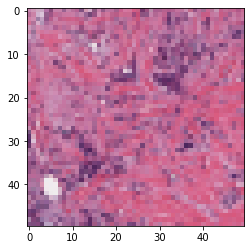

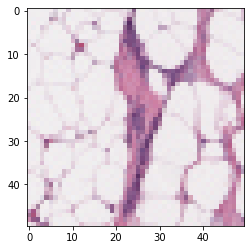

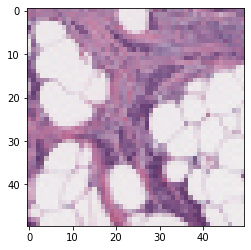

In [7]:
#Visualise 3 positive images before 180 degrees rotation
for i in range(3):
    
    #Process image by reshaping and converting it to uint8
    img= deg_180_img[len(deg_180_idx)-1-i]
    img_array=img.reshape(50,50,3)
    img_array = img_array.astype(np.uint8)

    #Display image
    plt.imshow(img_array)
    plt.show()

In [8]:
#Rotate allocated positive images by 180 degrees
for j in range(len(deg_180_img)):

    #Process image by reshaping and converting it to uint8
    img= deg_180_img[j]
    img_array=img.reshape(50,50,3)
    img_array =img_array.astype(np.uint8)
    
    #Rotate image by 180 degrees and update image at the same position
    rot = imutils.rotate(img_array, angle=180)
    new_img = rot.reshape([1,7500])
    deg_180_img[j] = new_img


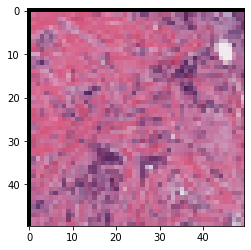

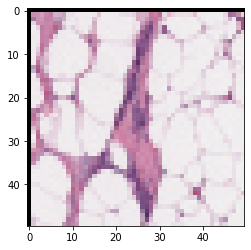

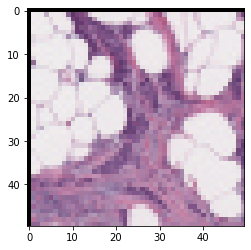

In [9]:
#Visualise 3 positive images after 180 degrees rotation
for i in range(3):
    
    #Process image by reshaping and converting it to uint8
    img= deg_180_img[len(deg_180_idx)-1-i]
    img_array=img.reshape(50,50,3)
    img_array = img_array.astype(np.uint8)

    #Display image
    plt.imshow(img_array)
    plt.show()

### Update original dataset with rotated images
After the images have been processed, these images will be used as the new dataset and saved in a new csv file. An empty array will be created to store these images. This is done so that it is easier to verify whether data is stored in place. According to the indices that are assigned to each dataset, the images are stored in the empty matrix. This new matrix will be saved to a csv file to train the ResNet18 network.

In [10]:
#Create empty array with 10000 rows (Number of images) and 7500 columns 
#(Number of pixels per image * Number of colour channels)
final_data=np.zeros((10000,7500))

#Storing images into its corresponding index in the empty array
#Store positive images after 90 degrees rotation
for i in range(len(deg_90_idx)):
    final_data[deg_90_idx[i]] = deg_90_img[i]
    
#Store positive images after 180 degrees rotation    
for j in range(len(deg_180_idx)):
    final_data[deg_180_idx[j]] = deg_180_img[j]    
    
#Store positive images without rotation    
for k in range(len(deg_0_idx)):
    final_data[deg_0_idx[k]] = deg_0_img[k]   
    
#Store negative images     
for m in range(len(negative)):
    final_data[negative[m]] = data[negative[m]]

### Verify if data is stored correctly in the empty array
We can accomplish this by printing out 5 image data from the negative images and 5 image data from the positive images. The data of the negative images should be exactly the same as the previous image data as their index are not changed and they are not rotated. For the positive images, most of the data should be different as 90% of them have undergone rotation of 90 degrees and 180 degrees respectively.

In [11]:
#Printing statement indicating negative images
print("\nNegative images\n")

#Print data of 5 negative images
for i in range(5):
    print(final_data[negative[i]])
    print(data[negative[i]])
    print("\n")

#Printing statement indicating positive images
print("\nPositive images\n")

#Print data of 5 positive images    
for i in range(5):
    print(final_data[positive[i]])
    print(data[positive[i]])
    print("\n")


Negative images

[162. 110. 158. ... 156.  84. 138.]
[162. 110. 158. ... 156.  84. 138.]


[129.  70. 120. ... 101.  52. 108.]
[129.  70. 120. ... 101.  52. 108.]


[216. 148. 179. ... 117.  82. 134.]
[216. 148. 179. ... 117.  82. 134.]


[244. 239. 243. ... 195. 159. 189.]
[244. 239. 243. ... 195. 159. 189.]


[212. 185. 207. ... 205.  98. 137.]
[212. 185. 207. ... 205.  98. 137.]



Positive images

[  0.   0.   0. ... 174. 108. 154.]
[149. 111. 152. ... 171. 117. 160.]


[  0.   0.   0. ...  97.  57. 119.]
[138.  72. 130. ... 122.  77. 133.]


[  0.   0.   0. ... 169.  95. 144.]
[226. 208. 212. ... 191. 124. 163.]


[  0.   0.   0. ... 141.  97. 146.]
[144.  79. 128. ... 158.  94. 138.]


[  0.   0.   0. ... 164. 109. 147.]
[113.  72. 119. ... 177. 131. 164.]




### Store updated array in new csv file
The updated array is now written into a new csv file to be used for training.

In [12]:
#Saving updated data to csv file
savetxt('rotated_data.csv', final_data, delimiter=',')

## Improving Pytorch Pretrained ResNet18 model
Using the dataset that is created in the previous section, we will finetune the pretrained ResNet18 model available from Pytorch models.

### Setting up device

In [13]:
#Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Setting Parameters

Values of parameters are set in this section of the code. The parameters set includes batch size, number of epochs, learning rate, index of initial epoch, initial accuracy, desired input image size and number of workers used to create dataloaders.



In [14]:
#Set batch size
batch_size     = 64

#Set number of epochs
num_epochs     = 10

#Set learning rate of optimizer
learning_rate  = 1e-4

#Initialise the index of starting epoch
start_epoch    = 0

#Set initial accuracy 
best_valid_acc = 0

#Set desired input image size 
image_size     = 64

#Set number of workers
n_workers = 0

### Set up save directory for the best model

In [15]:
#Set save_cehckpoint to False to initialise no checkpoints are saved
save_checkpoint = False

#Set up save directory
save_dir = 'Models'

#Set up model name
model_name = 'Res_18'

### Get random index to assign data to train data, validation data and test data
Since there are 10000 images, each with one label, we need to ensure that the data distribution in train data, validation data and test data are equal. To do this, we can create a list of numbers, whereby it contains a sequence of numbers between 0 - 9999 that is randomly distributed. We will use a random seed to ensure that we will always get the same random distribution.

After that, we will assign the first 8000 numbers in this sequence to be the indices of the images and labels for the training data. Likewise, we do the same for validation data and test data by assigning the following 1000 indices and 1000 indices to both categories respectively. 

In [16]:
#Get random index from 0 to 9999
indices = np.random.RandomState(seed=31).permutation(10000)

#Assign indices randomly as dataset index for training data, validation data and test data
training_idx, validation_idx,test_idx = indices[:8000], indices[8000:9000], indices[9000:]

### Create class for the dataset
A class called ImgData is created for the dataset to enable the use of dataloader for the training. The training, validation and testing indices obtained in the previous section are used in this class to assign data to training data, validation data and testing data

For all training set, validation set and testing set, the chosen images are reshaped into an array with the size of N * 50 * 50 * 3, where N is the number of images for training set, validation set or testing set. This is to ensure that each image will have its original dimension, that is height of 50 pixels, width of 50 pixels and 3 colour channels RGB. Their labels will be reshaped into a N * 1 column vector and typecasted into LongTensor to be used for training. 

Now, for each N value, there will be an image with its corresponding label. Then, the images will be typecasted to have float32 type so that the images can be used for training.

In [17]:
class ImgData(Dataset):
    
    #Function that creates dataloaders
    def __init__(self,trn_val_tst = 0, transform = None):
        #Load image array
        new_data = torch.from_numpy(loadtxt('rotated_data.csv', delimiter=','))
        
        #Convert image array to float by dividing it with 255 as image pixels range between 0 - 255 for uint8
        new_data = new_data/255 
        
        #Load label array and type cast them into LongTensor
        label = torch.from_numpy(loadtxt('label.csv', delimiter=',')).type(torch.LongTensor)
        
        #If the data required is training data
        if trn_val_tst == 0:
            #Create training data by assigning training images and their labels using training indices obtained previously
            self.images = new_data[training_idx].reshape(len(training_idx),50,50,3)
            self.labels = label[training_idx].reshape(len(training_idx),1).type(torch.LongTensor)
            
        #If the data required is validation data            
        elif trn_val_tst == 1:
            #Create validation data by assigning validation images and their labels using validation indices obtained previously
            self.images = new_data[validation_idx].reshape(len(validation_idx),50,50,3)
            self.labels = label[validation_idx].reshape(len(validation_idx),1).type(torch.LongTensor)
            
        #If the data required is testing data     
        else:
            #Create testing data by assigning testing images and their labels using testing indices obtained previously
            self.images = new_data[test_idx].reshape(len(test_idx),50,50,3)
            self.labels = label[test_idx].reshape(len(test_idx),1).type(torch.LongTensor)
            
        #Transform images to float and typecast the images to float32 type
        self.images = np.float32(self.images)/1.0
        
        #Transform images using transform set by user
        self.transform = transform

    #Function that defines the length of the requested dataset
    def __len__(self):
        return len(self.labels)

    #Dunction that gets the required images and labels
    def __getitem__(self, idx):
        
        #If the index given is a tensor, convert the index tensor to list
        if torch.is_tensor(idx):
            idx = idx.tolist()
   
        #The images and labels will be obtained via the converted indices
        sample = self.images[idx,:]
        labels = self.labels[idx]
  
        #The images will also be transformed using the user defined transform
        sample = self.transform(sample)
        
        return sample, labels

### Prepare a composition of transforms
We can define a composition of transforms using transformsCompose(). The images are transformed into tensors and resized to the desired input image size, which is set as 64 in this case. Then, these images are normalised using mean and standard deviation of all images per channel. As in the previous section, the images have been rotated as stated in the journal "A machine learning model for detecting invasive ductal carcinoma with Google Cloud AutoML Vision". Since we are following the procedure of this journal, data augmentation is unnecessary.

In [18]:
#Set up transform composition
transform = transforms.Compose([
            transforms.ToTensor(), #Convert image to tensor
            transforms.Resize(image_size), #Resize image to desired input image size
            transforms.Normalize(mean=[0.6841, 0.6804, 0.6832],
                                 std=[0.1960, 0.1945, 0.1948])]) #Normalise images according to each colour channel

### Define the training set, validation set and testing set
We can now define our training set, validation set and testing set using the ImgData class that is created.

In [19]:
train_set = ImgData(trn_val_tst=0, transform=transform) 
val_set = ImgData(trn_val_tst=1, transform=transform) 
test_set = ImgData(trn_val_tst=2, transform=transform) 

### Verify the number of images and labels in training set, validation set and testing set
We can check if the training set, validation set and testing set are assigned as desired. Note that training set occupies 70% of the whole dataset (the most), validation set takes 10% of the whole dataset (the least), and testing set takes the remaining 20%.

In [20]:
#Printing statements for number of data in training set, validation set and testing set respectively
print(f'Number of training examples: {len(train_set)}')
print(f'Number of validation examples: {len(val_set)}')
print(f'Number of testing examples: {len(test_set)}')

Number of training examples: 8000
Number of validation examples: 1000
Number of testing examples: 1000


### Create training data dataloader, validation data dataloader and testing data dataloader
Dataloader for training data, validation data and testing data are created to aid us in training our model.

In [21]:
#Create training data dataloader, validation data dataloader and testing data dataloader
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)

### Create function that normalizes image
This function is created to ensure that each image pixels is always between a value of 0 to 1

In [22]:
#This Function will allow us to scale an images pixel values to a value between 0 and 1
def normalize_img(img):
    mins = img.min(0, keepdims = True).min(1, keepdims = True) #Get minimum pixel value of one image
    maxs = img.max(0, keepdims = True).max(1, keepdims = True) #Get maximum pixel value in that image
    return (img - mins)/(maxs - mins) #Return normalized image

### Visualise the data 
We can now visualise the data that we are going to train our network with.

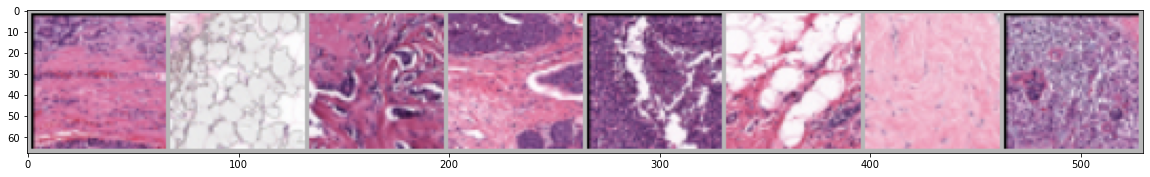

In [23]:
#Set figure size
plt.figure(figsize = (20,10))

#Obtain images in one batch from trainloader
images, labels = next(iter(trainloader))

#Plot out 8 images in the chosen batch
out = torchvision.utils.make_grid(images[0:8])
plt.imshow(normalize_img(out.numpy().transpose((1, 2, 0))))

#Show the images plotted
plt.show()

### Create a ResNet18 from the pytorch "models" module
The ResNet18 model in pytorch "models" module is a reasonably sized model at 18 layers deep.

ResNet Paper https://arxiv.org/pdf/1512.03385.pdf

https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.resnet50

We will use the pretrained ResNet18 model from Pytorch and perform transfer learning.

In [24]:
#Import ResNet18 from the pytorch "models" module
Res_net = models.resnet18(pretrained=True).to(device)

### Unfreeze all layers in ResNet18
We can unfreeze all layers in ResNet18 model that we have imported so that we can modify the layers in the model.

In [25]:
#Loop through all the learnable parameter objects (from the layers)
for param in Res_net.parameters():
    #Set "requires_grad" to True for all layers to unfreeze them
    param.requires_grad = True 

### Print out the architecture of the imported ResNet18 model
We can view the ResNet18 model that we have imported.

In [26]:
#Print out the imported ResNet18 network architecture
print(Res_net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Modify the last layer 
We can alter the model by changing the last layer, which is a fully connected layer, so that it will only output two classes. We want the model to output 0 if it predicts the sample is not cancerous (No IDC) and output 1 if it predicts the sample is cancerous (with IDC).

In [27]:
#Get the number of in_features into the last fc layer
num_ftrs = Res_net.fc.in_features

#Redefine the last fc layer with a linear layer with 2 outputs, this layer's weights will be randomly initialised
Res_net.fc = nn.Linear(num_ftrs, 2).to(device)

### Check output dimension
We can check the output dimension by passing input images in training data dataloader through the network. (These input images are obtained from one batch of the training data dataloader while we plot out the images previously) Then, we can see the output dimension by printing it out. Since we have set the batch size to 64, we expect the output dimension to be 64 * 1, which is a column vector that contains a label for each image in that batch.

In [28]:
#Pass image in one batch through the ResNet18 network
out = Res_net(images.to(device))

#Print output to check
print(out.shape)

torch.Size([64, 2])


### Set up optimizer and loss function
We will use Adam optimizer in this case and Cross Entropy Loss. Adam optimizer is used because it is generally faster compared to Stochastic Gradient Descent (SGD). Cross Entropy Loss is used because it is good to be appplied for classification problems.

In [29]:
#Set up optimizer and its learning rate
optimizer = optim.Adam(Res_net.parameters(), lr = learning_rate)

#Define loss function as Cross Entropy Loss
Loss_fun = nn.CrossEntropyLoss()

### Create path to save the best model

In [30]:
#Create Save Path from save_dir and model_name
save_path = os.path.join(save_dir, model_name + ".pt")

#Create the save directory if it does not exist
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

### Define the accuracy calculator
To obtain the prediction of the model, we will use obtain the index where the output value is maximum. We will take this prediction and check it against the true label of the particular images to check the accuracy of the model.

In [31]:
def calculate_accuracy(fx, y):
    #Obtain index at maximum output value
    preds = fx.max(1, keepdim=True)[1]
    
    #Find the number of correct labels by checking number of predictions that are the same as the true labels
    correct = preds.eq(y.view_as(preds)).sum()
    
    #Calculate accuracy
    acc = correct.float()/preds.shape[0]
    
    return acc

### Define the training process

In [32]:
#This function should perform a single training epoch using our training data
def train(net, device, loader, optimizer, loss_fun, loss_logger):
    
    #Initialise counters
    epoch_loss = 0
    epoch_acc = 0
    
    #Set Network to train mode
    net.train()
    
    #For every image from every batch from the desired dataloader
    for i, (x, y) in enumerate(loader):
        
        #load images and labels to device
        x = x.to(device) # x is the image
        y = y.to(device) # y is the corresponding label
        y=y.squeeze()  
        
        #Forward pass of image through network and get output
        fx = net(x)
        
        #Calculate loss using loss function
        loss = loss_fun(fx, y)
        
        #Calculate the accuracy
        acc = calculate_accuracy(fx, y)

        #Zero the Gradents
        optimizer.zero_grad()
        
        #Backpropagate the gradents to improve the model
        loss.backward()
        
        #Do a single optimization step
        optimizer.step()
        
        #Sum up all the losses and accuracies for an epoch
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
        #Store the loss values in loss logger for plotting to see how the model performs
        loss_logger.append(loss.item())

        #Clears output of running cell
        clear_output(True)
        
        #Printing current status of training
        print("TRAINING: | Itteration [%d/%d] | Loss %.2f |" %(i+1 ,len(loader) , loss.item()))
        
    #Return average loss and accuracies from the epoch as well as the logger array       
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger

### Define the testing process

In [33]:
#This function should perform a single evaluation epoch and will be passed our validation or evaluation/test data
#It WILL NOT be used to train our model
def evaluate(net, device, loader, loss_fun, loss_logger = None):
    
    epoch_loss = 0
    epoch_acc = 0
    
    #Set network in evaluation mode
    #Layers like Dropout will be disabled
    #Layers like Batchnorm will stop calculating running mean and standard deviation and use current stored values
    net.eval()
    
    #We do not need the gradient for backpropagation etc
    with torch.no_grad():
        
        #For every image from every batch from the desired dataloader
        for i, (x, y) in enumerate(loader):
            
            #load images and labels to device
            x = x.to(device)
            y = y.to(device)
            y=y.squeeze()
            
            #Forward pass of image through network
            fx = net(x)
            
            #Calculate loss using loss function
            loss = loss_fun(fx, y)
            
            #Calculate the accuracy
            acc = calculate_accuracy(fx, y)
            
            #Sum up all the losses and accuracies for an epoch
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            #Store the loss value for plotting if we passed a logger to the function
            if not (loss_logger is None):
                loss_logger.append(loss.item())
            
            #Clears output of running cell
            clear_output(True)
            
            #Printing current status of testing
            print("EVALUATION: | Itteration [%d/%d] | Loss %.2f | Accuracy %.2f%% |" %(i+1 ,len(loader), loss.item(), 100*(epoch_acc/ len(loader))))
    
    #Return average loss and accuracies from the epoch as well as the logger array    
    return epoch_loss / len(loader), epoch_acc / len(loader), loss_logger

### Set up learning rate schedular  
It can be useful to start with a high learning rate and then decrease it after some time allowing the optimiser to "fine tune" the model<br>
There are many different ideas about how to change the learning rate over epochs, here we will create a simple "linear decay" schedular manually.<br>
Pytorch also has automatic Learning rate scheduling

[Learning rate scheduling](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

In [34]:
#Create a function that will linearly decay the learning rate every epoch
def lr_linear_decay(epoch_max, epoch, lr):
    lr_adj = ((epoch_max - epoch)/epoch_max)*lr
    
    #Update the learning rate parameter of the optimizer
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_adj

### Create lists to record losses and accuracies
In this section, lists are created for training and validation losses and accuracies respectively. This is to store their values for plotting to observe the overall performance of the model.

In [35]:
#Log the training and validation losses
training_loss_logger = []
validation_loss_logger = []

#Log the training and validation accuracies
training_accuracy_logger = []
validation_accuracy_logger = []

### Training starts here

In [36]:
#This cell implements our training loop

#Record the start time
Start_time = time.time()

for epoch in range(start_epoch, num_epochs):
    #Implement the linear decay of the learning rate
    lr_linear_decay(num_epochs, epoch, learning_rate)
    
    #Call the training function and pass training dataloader etc
    train_loss, train_acc, training_loss_logger = train(Res_net, device, trainloader, optimizer, Loss_fun, training_loss_logger)
    training_accuracy_logger.append(train_acc*100)
    
    #Call the evaluate function and pass validation dataloader etc
    valid_loss, valid_acc, validation_loss_logger = evaluate(Res_net, device, valloader, Loss_fun, validation_loss_logger)
    validation_accuracy_logger.append(valid_acc*100)
    
    #If this model has the highest performace on the validation set, then save a checkpoint
    #{} define a dictionary, each entry of the dictionary is indexed with a string
    if (valid_acc > best_valid_acc) and save_checkpoint:
        print("Saving Model")
        torch.save({
            'epoch':                 epoch,
            'model_state_dict':      Res_net.state_dict(),
            'optimizer_state_dict':  optimizer.state_dict(), 
            'train_acc':             train_acc,
            'valid_acc':             valid_acc,
        }, save_path)
    
    #Print training status at the end of each epoch
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% |')

End_time = time.time()

EVALUATION: | Itteration [16/16] | Loss 0.38 | Accuracy 96.37% |
| Epoch: 10 | Train Loss: 0.000 | Train Acc: 100.00% | Val. Loss: 0.173 | Val. Acc: 96.37% |


### Print training time used to train the ResNet18 model

In [37]:
#Print training time used
print("Training time %.2f seconds" %(End_time - Start_time))

Training time 522.63 seconds


### Plot training and validation losses
The training loss is plotted in yellow while the validation loss is plotted in black.

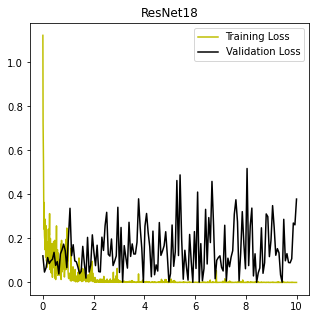

In [38]:
#Set up figure
plt.figure(figsize = (5,5))

#Set up vectors required for plotting training loss
train_x = np.linspace(0, num_epochs, len(training_loss_logger))

#Plot training loss
plt.plot(train_x, training_loss_logger, c = "y")

#Set up vectors required for plotting validation loss
valid_x = np.linspace(0, num_epochs, len(validation_loss_logger))

#Plot validation loss
plt.plot(valid_x, validation_loss_logger, c = "k")

#Print title and legend of the plot
plt.title("ResNet18")
plt.legend(["Training Loss", "Validation Loss"])

#Show the plot
plt.show()

### Plot training and validation accuracies
The training accuracy is plotted in yellow while the validation accuracy is plotted in black.

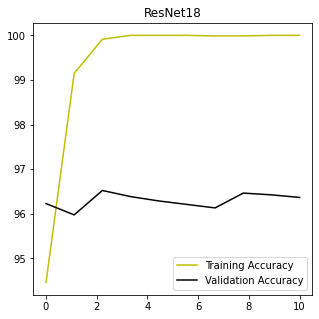

In [39]:
#Set up figure
plt.figure(figsize = (5,5))

#Set up vectors required for plotting training accuracy
train_x = np.linspace(0, num_epochs, len(training_accuracy_logger))

#Plot training accuracy
plt.plot(train_x, training_accuracy_logger, c = "y")

#Set up vectors required for plotting validation accuracy
valid_x = np.linspace(0, num_epochs, len(validation_accuracy_logger))

#Plot validation accuracy
plt.plot(valid_x, validation_accuracy_logger, c = "k")

#Print title and legend of the plot
plt.title("ResNet18")
plt.legend(["Training Accuracy", "Validation Accuracy"])

#Show the plot
plt.show()

### Evaluate the model using test set dataloader
The model is evaluated finally using test data and the final accuracy is observed.

In [40]:
#call the evaluate function and pass the evaluation/test dataloader etc
test_loss, test_acc, _ = evaluate(Res_net, device, testloader, Loss_fun)

EVALUATION: | Itteration [16/16] | Loss 0.10 | Accuracy 96.72% |


### Create function to calculate F1 score

In [41]:
def total_f1_score(pred,y,true_pos,false_pos,true_neg,false_neg):
    
    #Caters for true positive
    if(pred==y and y == 1):
        true_pos+=1
        
    #Caters for true negative        
    elif (pred==y and y == 0):
        true_neg+=1
        
    #Caters for false negative        
    elif(pred!=y and y==1):
        false_neg+=1
        
    #Caters for false positive          
    elif(pred!=y and y==0):
        false_pos+=1
    
    return true_pos,false_pos,true_neg,false_neg

### Define variables for validation and testing
True positive, true negative, false positive and false negative are created for both validation and testing in order to calculate their F1 scores and balanced accuracy

In [42]:
#Variables for validation
#True positive
val_true_pos = 0

#True negative
val_true_neg = 0 

#False positive
val_false_pos = 0

#False negative
val_false_neg = 0

In [43]:
#Variables for testing
#True positive
test_true_pos = 0

#True negative
test_true_neg = 0

#False positive
test_false_pos = 0

#False negative
test_false_neg = 0

### Find the confusion matrix for the validation set and the test set
We can find the confusion amtrix for each dataset by passing the data through the trained ResNet18 network.

In [44]:
#Create an empty array for validation set confusion matrix
valid_set_confusion_matrix = np.zeros((2,2))

#Row is for real labels
#Column is for assigned labels

with torch.no_grad():
    for (x, y) in (val_set):
    
        #Expand input images to 4D
        x = np.expand_dims(x, axis=0)
        
        #Convert input image to torch before passing it through ResNet18
        x = torch.from_numpy(x).to(device)
        
        #Pass input image through the trained ResNet18
        fx = Res_net.forward(x)
        
        #Store output at CPU
        fx=fx.cpu()
        
        #Find prediction for each image
        pred = fx.max(1, keepdim=True)[1]
        
        #Calculate F1 score for validation set
        val_true_pos,val_false_pos,val_true_neg,val_false_neg = total_f1_score(pred,y,val_true_pos,val_false_pos,val_true_neg,val_false_neg)
        
        #Find the row that each image belongs to in the confusion matrix
        row=int(y)
        
        #Find the column that each image belongs to in the confusion matrix
        col=int(pred)
        
        #Increment the number in the destination cell by one in the confusion matrix
        valid_set_confusion_matrix[row][col]+=1

In [45]:
#Create an empty array for test set confusion matrix
test_set_confusion_matrix = np.zeros((2,2))

#Row is for real labels
#Column is for assigned labels

with torch.no_grad():
    for (x, y) in (test_set):
    
        #Expand input images to 4D
        x = np.expand_dims(x, axis=0)
        
        #Convert input image to torch before passing it through ResNet18
        x = torch.from_numpy(x).to(device)
        
        #Pass input image through the trained ResNet18
        fx = Res_net.forward(x)
        
        #Store output at CPU
        fx=fx.cpu()
        
        #Find prediction for each image
        pred = fx.max(1, keepdim=True)[1]
        
        #Calculate F1 score for test set
        test_true_pos,test_false_pos,test_true_neg,test_false_neg = total_f1_score(pred,y,test_true_pos,test_false_pos,test_true_neg,test_false_neg)
        
        #Find the row that each image belongs to in the confusion matrix
        row=int(y)
        
        #Find the column that each image belongs to in the confusion matrix
        col=int(pred)
        
        #Increment the number in the destination cell by one in the confusion matrix
        test_set_confusion_matrix[row][col]+=1    

In [46]:
#Printing validation set confusion matrix
print("Validation set confusion matrix:\n\n",valid_set_confusion_matrix)

#Printing new line
print("\n")

#Printing test set confusion matrix
print("Test set confusion matrix:\n\n",test_set_confusion_matrix)

Validation set confusion matrix:

 [[473.   7.]
 [ 29. 491.]]


Test set confusion matrix:

 [[512.   6.]
 [ 27. 455.]]


### Find F1 scores and balanced accuracy for validation set and test set
F1 scores and balanced accuracy can be found by using the information on true positive, false positive, true negative and false negative that are obtained in the previous part

In [47]:
#Find precision, recall, sensitivity, specificity, F1 score and balanced accuracy for validation set
#Find precision
val_precision = (val_true_pos)/(val_true_pos+val_false_pos)

#Find recall
val_recall = (val_true_pos)/(val_true_pos+val_false_neg)

#Find sensitivity
val_sensitivity = val_true_pos/(val_true_pos+val_false_neg)

#Find specificity
val_specificity = val_true_neg/(val_true_neg+val_false_pos)

#Find F1 score
val_f1_score = (2*val_precision*val_recall)/(val_precision+val_recall)

#Find balanced accuracy
val_bal_acc = (val_sensitivity+val_specificity)/2

In [48]:
#Find precision, recall, sensitivity, specificity, F1 score and balanced accuracy for test set
#Find precision
test_precision = (test_true_pos)/(test_true_pos+test_false_pos)

#Find recall
test_recall = (test_true_pos)/(test_true_pos+test_false_neg)

#Find sensitivity
test_sensitivity = test_true_pos/(test_true_pos+test_false_neg)

#Find specificity
test_specificity = test_true_neg/(test_true_neg+test_false_pos)

#Find F1 score
test_f1_score = (2*test_precision*test_recall)/(test_precision+test_recall)

#Find balanced accuracy
test_bal_acc = (test_sensitivity+test_specificity)/2

In [49]:
#Printing validation set F1 score
print("Validation F1 score: ",val_f1_score)

#Printing validation set balanced accuracy
print("Validation balanced accuracy: ",val_bal_acc)

#Printing new line
print("\n")

#Printing test set F1 score
print("Test F1 score: ",test_f1_score)

#Printing test set balanced accuracy
print("Test balanced accuracy: ",test_bal_acc)

Validation F1 score:  0.9646365422396856
Validation balanced accuracy:  0.964823717948718


Test F1 score:  0.9650053022269354
Test balanced accuracy:  0.9662001954533075
